# Cleaning, analysing and making an input/output system for a huge movie database

We found our database from kaggle.com. The database contains about 1,000,000 movies from the TMDB (The Movie DataBase) website.
https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies

# Data cleaning

We cleaned the dataset using Pandas in Python. The code drops columns we don't need, removes rows with missing values in the 'title' and 'imdb_id' columns, and removes duplicate rows based on the 'title' and 'release_date' columns. 
It also finds the most frequent data type among the columns and converts all columns to this common data type.

In [1]:
import pandas as pd

# Read the dataset from CSV file
SeriesData = pd.read_csv('TMDB_movie_dataset_v11.csv')

# Define columns to be dropped from the DataFrame
ToDrop = ['id','backdrop_path', 'original_title']

# Drop specified columns from the DataFrame
SeriesData.drop(ToDrop, axis=1, inplace=True)

# Drop rows where 'title' and 'imdb_id' are missing
SeriesData = SeriesData[SeriesData['title'] != '']
SeriesData = SeriesData[SeriesData['imdb_id'] != '']

# Drop duplicate rows based on 'title' and 'release_date' columns
SeriesData = SeriesData.drop_duplicates(subset=['title', 'release_date'])

# Choose the most frequent data type among columns
common_type = SeriesData.dtypes.value_counts().sort_values(ascending=False).index[0]

# Check each column and convert its data type to the common_type if needed
for column in SeriesData.columns:
    if SeriesData[column].dtype != common_type:
        SeriesData[column] = SeriesData[column].astype(common_type)

#print(SeriesData)

# Plotting

Next, we plotted some graphs using the data. 
Here are the used libraries.

In [ ]:
library(ggplot2) # For plotting
library(dplyr) # For data manipulation
library(tidyr) # For seperating rows by commas
library(forcats) # For reordering rows
library(RColorBrewer) # For color brewer package
library(wordcloud) # For plotting wordclouds

df <- read.csv("cleaned_movies.csv")

# Pie charts

First pie chart shows the top countries of production

In [ ]:
# Pie chart of countries of production

# Seperating the commas, adding frequency column
df_countries <- df %>% select(production_countries) %>%
  filter(production_countries != "") %>%
  separate_rows(production_countries, sep = ", ") %>%
  group_by(production_countries) %>%
  summarise(frequency = n()) %>%
  arrange(desc(frequency))

n_of_count <- nrow(df_countries) # number of countries
other_freq <- sum(df_countries[31:n_of_count, "frequency"]) # sum of other frequencies

# Make an "Other" row
new_row <- list(production_countries = "Other", frequency = other_freq)

# Take top 30, factor countries in order
df_countries <- df_countries %>%
  slice(1:30) %>%
  add_row(!!!new_row) %>%
  mutate(production_countries = factor(production_countries, levels = production_countries))

# Make a palette
pie_palette = c(brewer.pal(9, "Set1"), brewer.pal(8, "Dark2"), brewer.pal(8, "Set1"), brewer.pal(8, "Set3"))

# Pie chart 
ggplot(df_countries, aes(x = "", y = frequency, fill = production_countries)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  labs(title = "Countries of Production") +
  scale_fill_manual(values = pie_palette, name = "Countries of production")

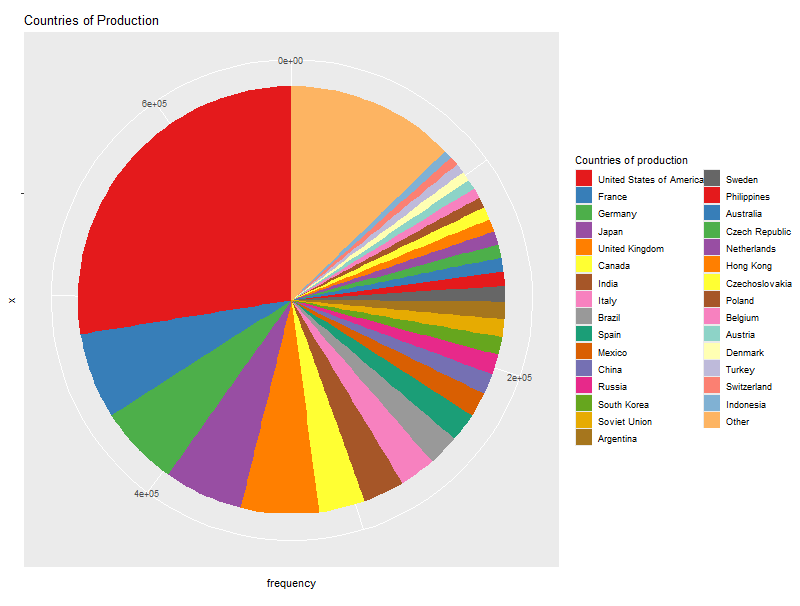

As we can see, the US is in the lead, while France, Germany, Japan and the UK have almost equal contribution.

Second pie chart shows the statuses of movies

In [ ]:
# Pie chart of status (released,..)

# add a frequency column
df_status <- df %>%
  select(status) %>%
  group_by(status) %>%
  summarise(Count = n())

# plot pie chart
ggplot(df_status, aes(x = "", y = Count, fill = status)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  labs(title = "Status")

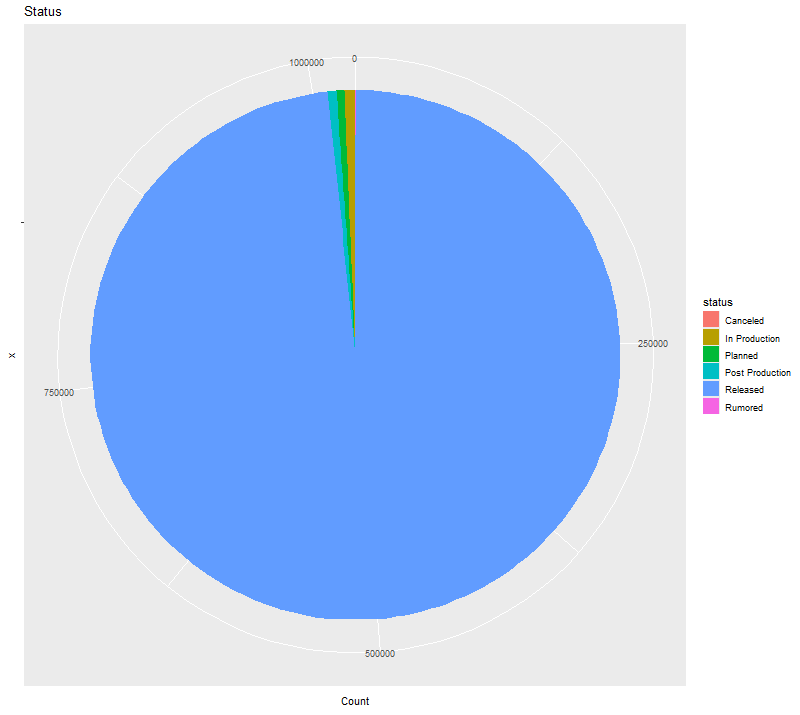

Most of the movies in the database are released

3rd pie chart shows the top companies of production

In [ ]:
# Pie chart of top companies of production

# Seperating the commas, adding frequency column
df_comp <- df %>% select(production_companies, adult) %>%
  filter(production_companies != "", adult == "False") %>%
  separate_rows(production_companies, sep = ", ") %>%
  group_by(production_companies) %>%
  summarise(frequency = n()) %>%
  arrange(desc(frequency))

# Take top 30, factor countries in order
df_comp <- df_comp %>%
  slice(1:30) %>%
  mutate(production_companies = factor(production_companies, levels = production_companies))

# Make a palette
pie_palette = c(brewer.pal(9, "Set1"), brewer.pal(8, "Dark2"), brewer.pal(8, "Set1"), brewer.pal(8, "Set3"))

# Pie chart 
ggplot(df_comp, aes(x = "", y = frequency, fill = production_companies)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  labs(title = "Companies of Production") +
  scale_fill_manual(values = pie_palette, name = "Companies of production")

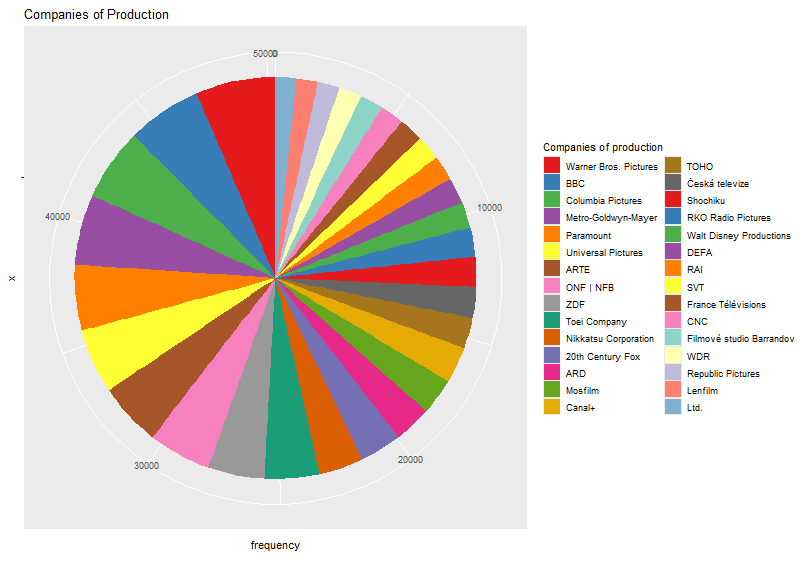

There isn't a big difference in contribution of companies of production. This means there isn't a single company that leads the curent industry, however, we cans see that Warner Bros Pictures has most movies in this dataset.

4th and final pie chart shows the percentage of adult movies

In [ ]:
# Adult movies

# Add a frequency column
df_adult <- df %>%
  select(adult) %>%
  group_by(adult) %>%
  summarise(frequency = n())

ggplot(df_adult, aes(x = "", y = frequency, fill = adult)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  labs(title = "Adult movies") 

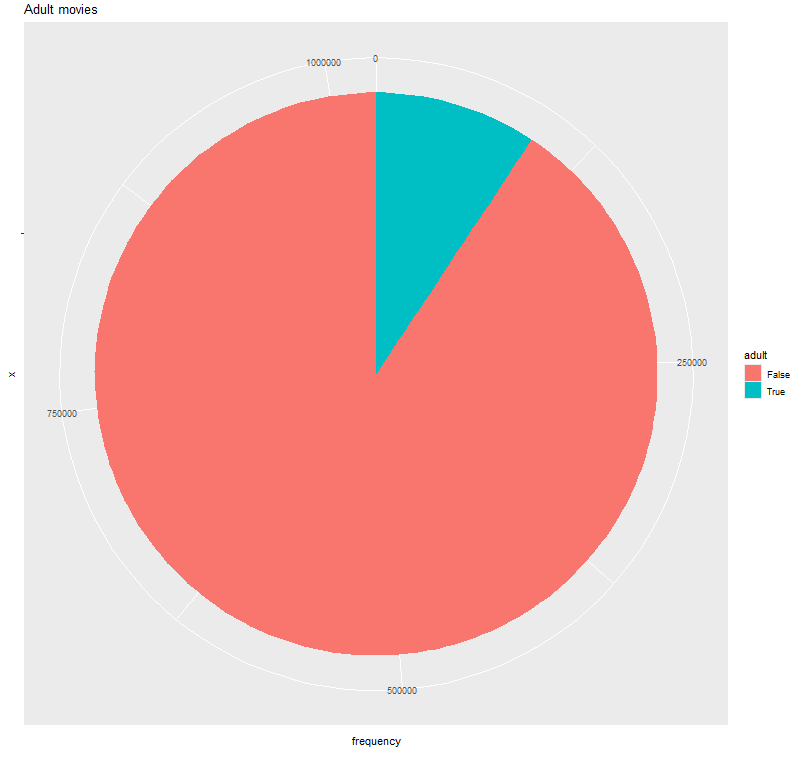

Around 10% of the movies are rated as an adult film.

# Barplots and histograms

Our 1st bar plot shows the genres and their frequencies

In [ ]:
# Plotting genres frequencies

# Seperating rows by the commas, to correctly count how many times each genre appears
# Removing rows with no genres
dfgenres <- df %>% select(genres) %>%
  separate_rows(genres, sep = ", ") %>%
  filter(genres != "")

# Reorder factor levels based on frequency of occurrence
dfgenres$genres <- fct_infreq(dfgenres$genres)

# Plot the barplot
ggplot(dfgenres, aes(x = genres, fill = genres)) +
  geom_bar(stat = "count") +
  theme(axis.text.x = element_text(angle = 45, size = 15)) +
  labs(title = "Times each genre occurs", x = "Genres")

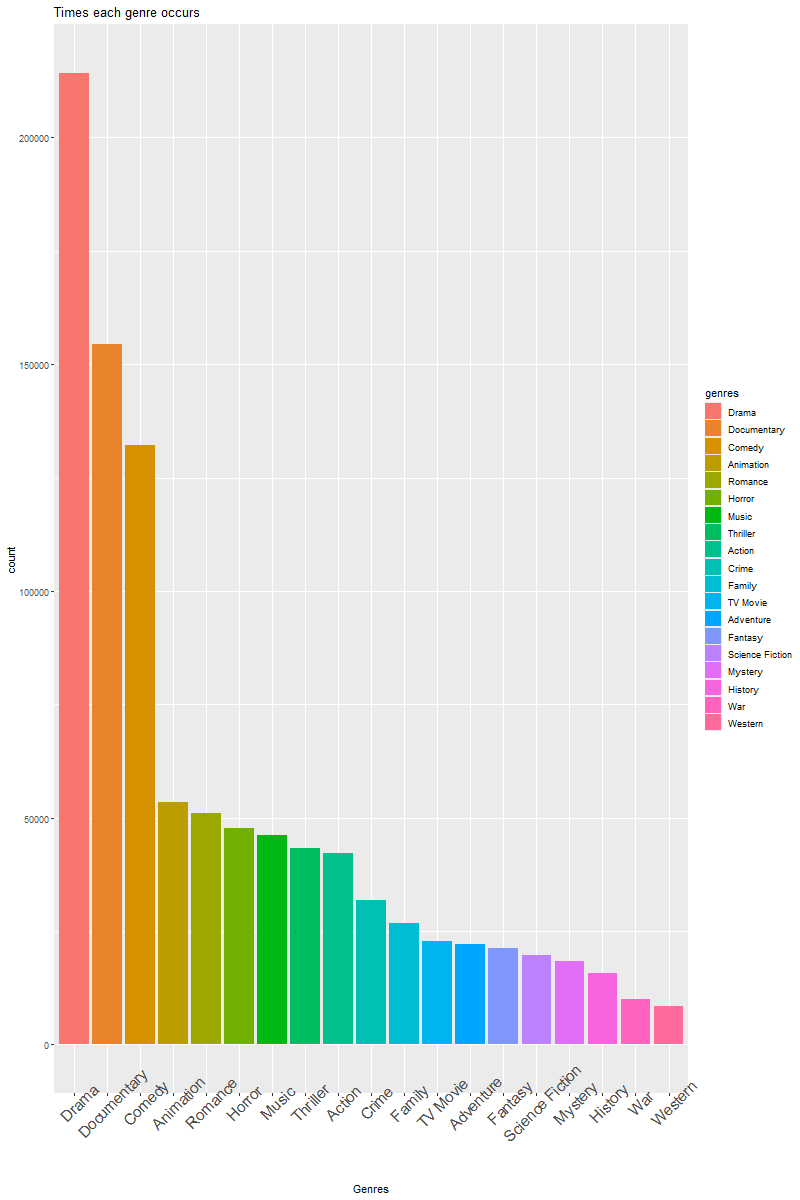

Drama, documentary and comedy are the leading genres, and they are far ahead of the 4th most common genre. War and western is the least common genres.

This histogram shows the profit made from the movies

In [ ]:
# Plotting revenue vs budget

# take dfrev of revenues and budgetsbugger than 10mil
dfrev <- df %>% select(revenue, budget)
dfrev <- dfrev[dfrev$revenue > 10000000 & dfrev$budget > 10000000, ]
dfrev <- dfrev %>% mutate(Profit = revenue - budget)

# Plot histogram with 100 bins and zoom in, logarithmic frequencies
ggplot(dfrev, aes(x = Profit)) +
  geom_histogram(fill = "#4fcc4f", color = "black", bins = 100) +
  scale_y_log10() +
  labs(title = "Distribution of Profit", x = "Profit", y = "Frequency") +
  xlim(-2e+08, 1e+09)

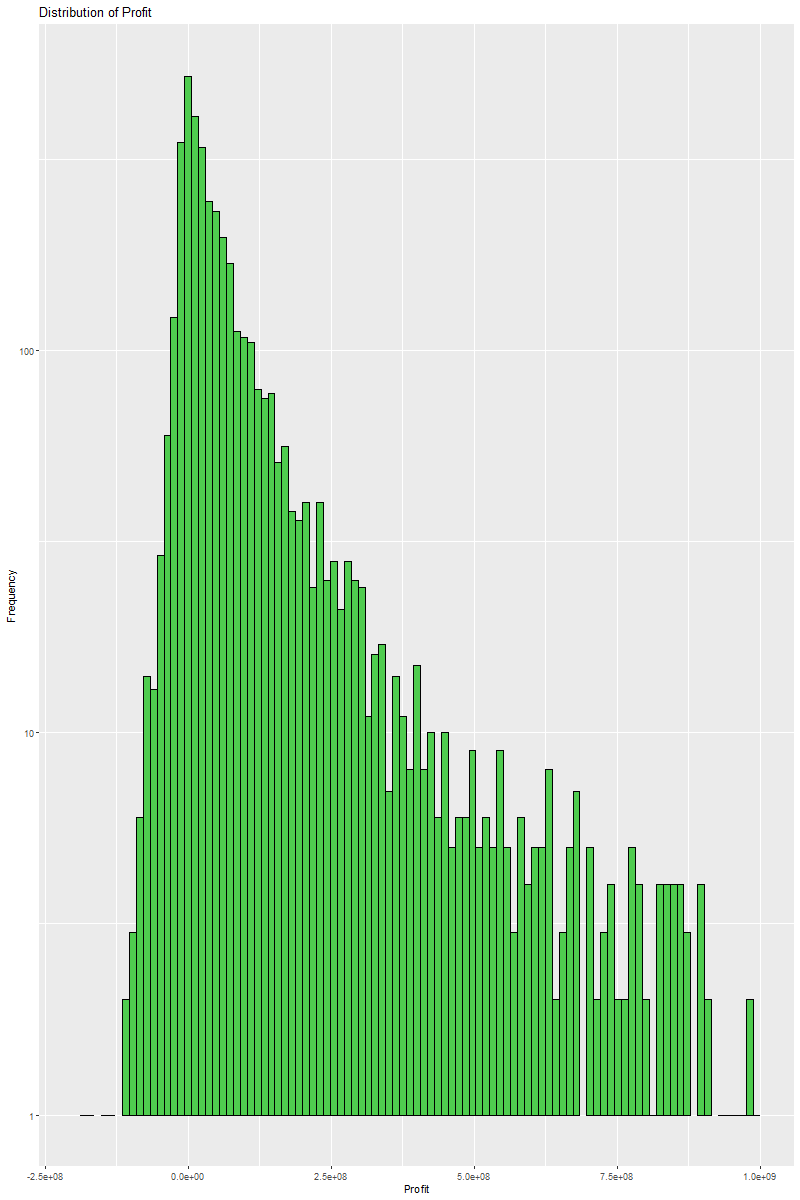

There are very few movies that had a negative profit. Most movies' profits are around the millions, and there are less than 5 movies that made a profit close to a billion, according to this dataset.

# Scatterplots

First scatterplot shows the popularity of movies vs their duration. It also shows their main languages

In [ ]:
# Scatterplot of popularity per duration, color representing languages

# Selecting our needed columns
dfdur <- df %>%
  select(popularity, runtime, original_language, title) %>%
  filter(runtime > 0, popularity > 100)

# Combine palettes from RColorBrewer, so the colors are distinct
combined_palette <- c(brewer.pal(9, "Set1"), brewer.pal(8, "Set2"), brewer.pal(8, "Set3"))

# Factor the languages, sort them by frequency
ggplot(dfdur, aes(x = popularity, y = runtime, color = factor(original_language, levels = names(sort(table(original_language), decreasing = TRUE))))) +
  geom_point(size = 7) +
  labs(title = "Popularity vs Duration", x = "Popularity", y = "Duration") +
  scale_color_manual(values = combined_palette, name = "Languages")

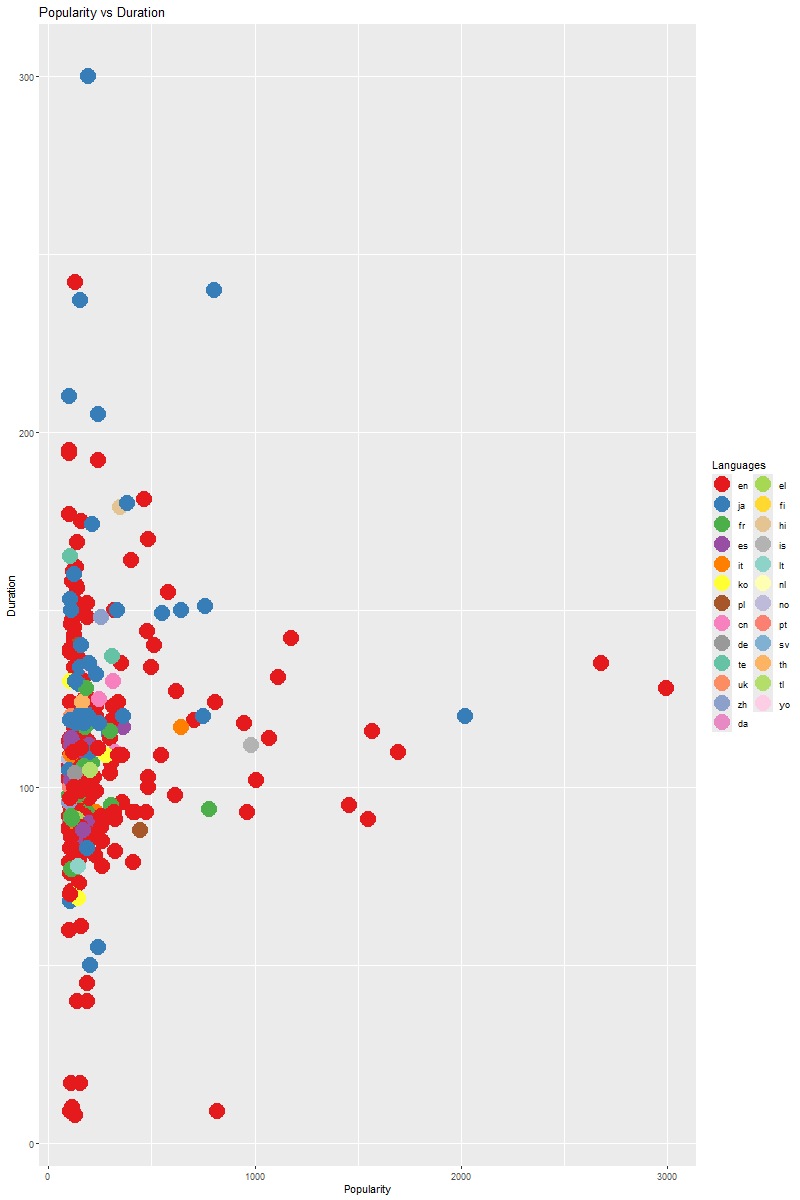

The plot shows that the more average the movies duration is, the more likely it is to be popular. The average duration is about 2 hours. The shorter or the longer the movie is, the less popular it will be. We can also see that most popular movies are in english, and in second place is japanese.

This next scatterplot shows number of votes vs the movie's average rating

In [ ]:
# Plotting votes and votecounts

# Taking movies with 1000+ votes
dfvotes <- df %>% select(vote_average, vote_count) %>%
  filter(vote_average > 0, vote_count > 1000)

# Plotting the scatterplot and adding a curved line
ggplot(dfvotes, aes(x = vote_average, y = vote_count)) +
  geom_point() +
  geom_smooth(method = "loess", se = FALSE, color = "red") +
  labs(title = "Scatter Plot of Vote Average vs. Vote Count",
       x = "Vote Average", y = "Vote Count")

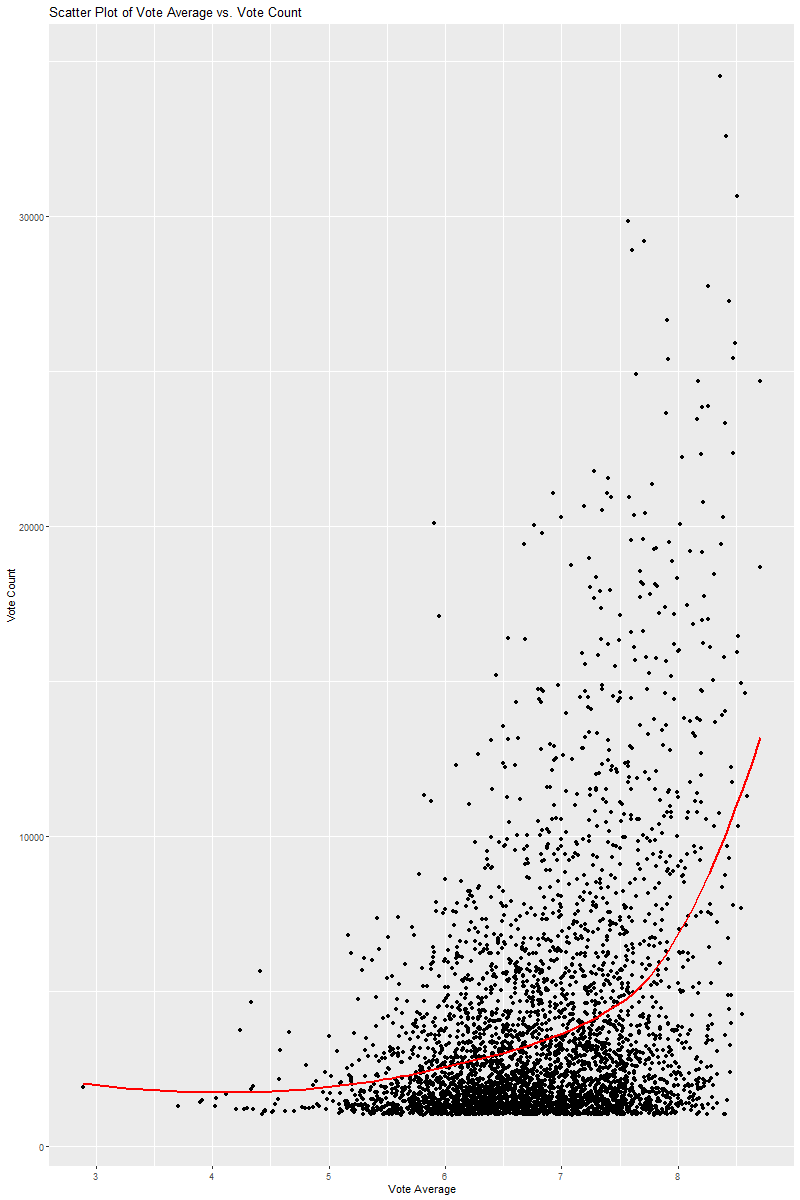

The line of best fit shows that the rating gets higher with the vote cound. People tend to vote more if they liked the movie.

The last scatterplot shows the popularity of movies vs their release date

In [ ]:
# Plotting popularity by release dates

# Filtering the data, taking popular films
dfrelease <- df %>% select(release_date, popularity) %>%
  filter(release_date != "", popularity > 50)

# String into date
dfrelease$release_date <- as.Date(dfrelease$release_date)

# Plotting the scatterplot
ggplot(dfrelease, aes(x = release_date, y = popularity)) +
  geom_point() +
  scale_y_log10() +
  labs(title = "Release Date vs. Popularity",
       x = "Release Date", y = "Popularity")

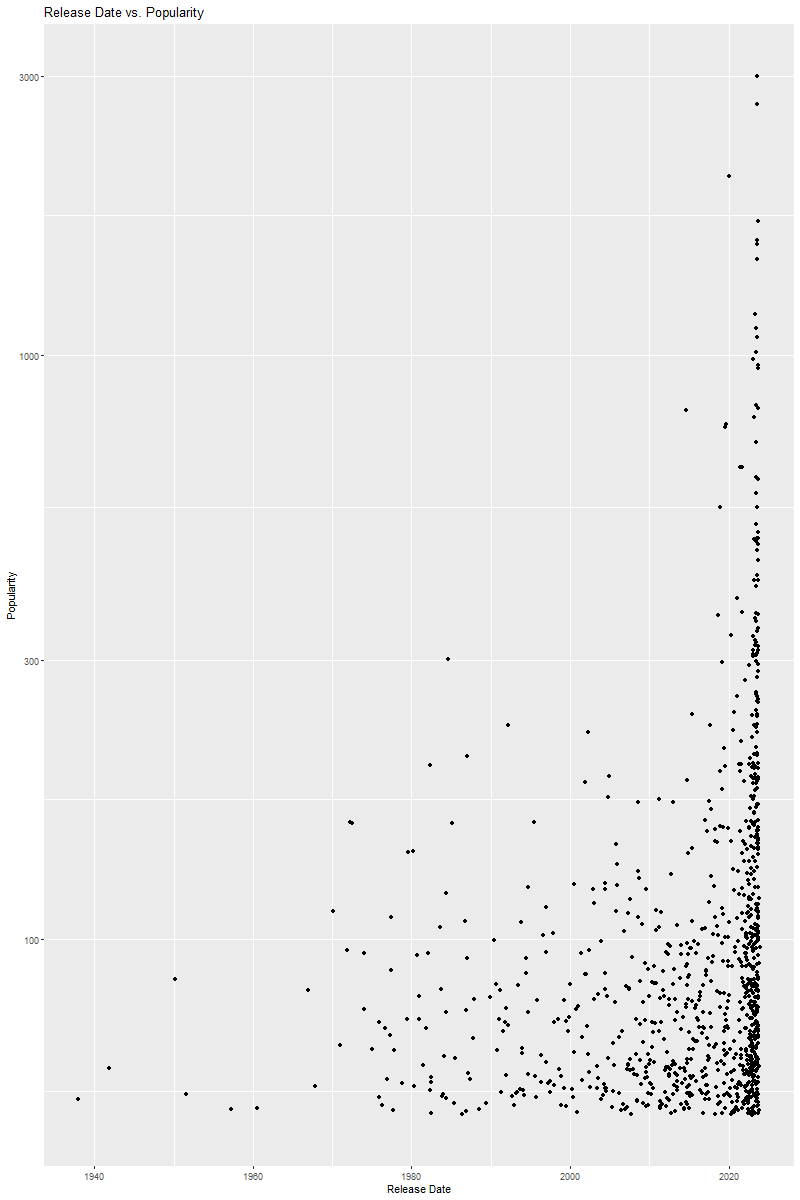

The plot shows that more recent movies are way more popular. 

# Line graphs

1st line graph shows movie frequencies by their genres

In [ ]:
# Plotting movie frequencies by their genres

# Seperate by genres, release dates, and genre frequencies
library(lubridate)
dfpop <- df %>%
  separate_rows(genres, sep = ", ") %>%
  select(genres, release_date) %>%
  filter(genres != "", release_date != "")

# Floor dates into months
dfpop$release_date <- as.Date(dfpop$release_date)
dfpop$release_date <- floor_date(dfpop$release_date, unit = "month")

# Range for more accuracy
dfpop <- dfpop %>%
  filter(year(release_date) < 2024, year(release_date) > 1930)

# Group by months and genres
dfpop <- dfpop %>%
  group_by(release_date, genres) %>%
  summarise(Frequency = n())

print(n = 40, dfpop)
# Histogram, colors representing different genres, faceted
ggplot(dfpop, aes(x = release_date, y = Frequency, color = genres)) +
  geom_smooth(method = "loess", se = FALSE, span = 0.9) +
  labs(title = "Movies by Genres", x = "Time", y = "Frequency") +
  facet_grid(genres ~ ., scales = "free_y")

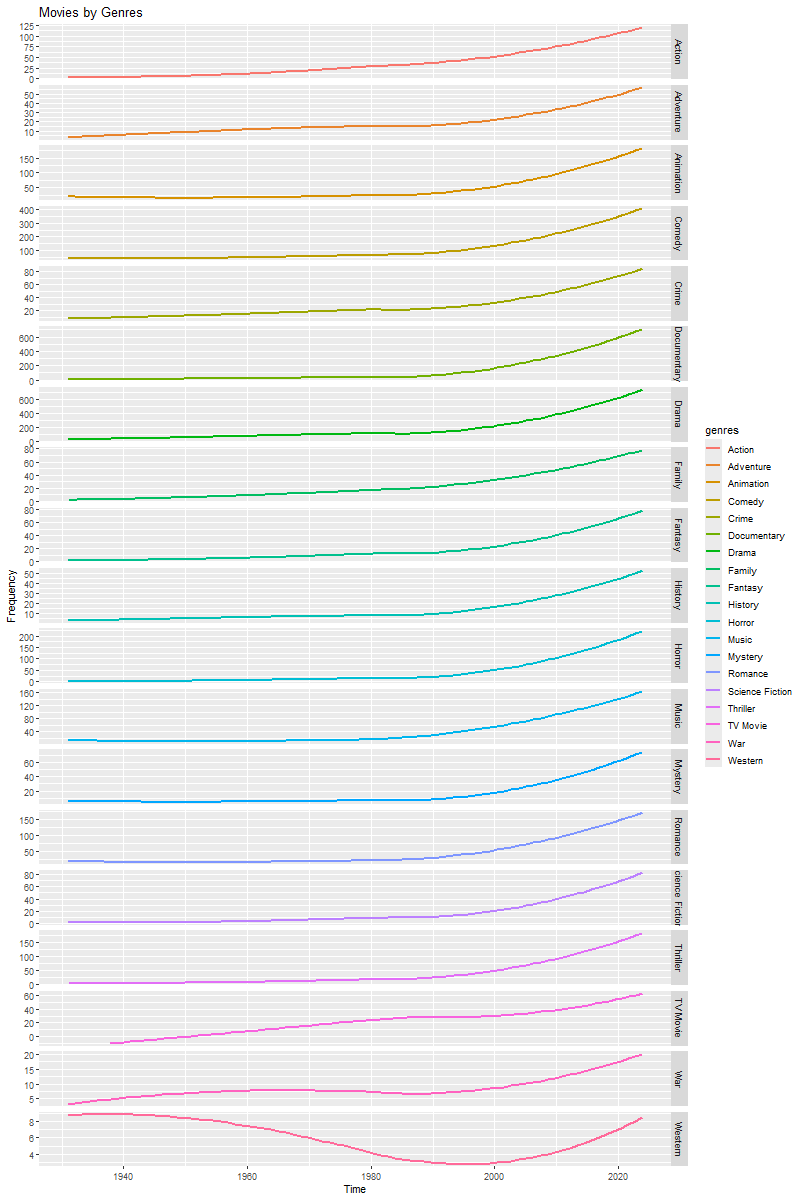

The line graphs show that almost all genres progressed equally, except for western. Western movies were most common before 1970s, then they became extremely uncommon between 1980-2000, and they are experiencig an increase again.

The next line plot shows movie popularities based on genres

In [ ]:
movies <- slice(df, 1:100)
# Separate genres into rows
df_genre <- movies %>%
  separate_rows(genres, sep = ", ") %>%
  filter(!is.na(popularity))  # Remove rows with NA popularity

# Convert release_date to date format
df_genre$release_date <- as.Date(df_genre$release_date)

# Aggregate the popularity data by genre and release date
popularity_by_genre <- df_genre %>%
  group_by(genres, release_date) %>%
  summarize(avg_popularity = mean(popularity, na.rm = TRUE))

genres_to_remove <- c("Western", "War", "History", "Music", "Romance")

# Filter genres
popularity_by_genre <- popularity_by_genre %>%
  filter(!genres %in% genres_to_remove)

# Plot movie popularity over time by genre
ggplot(popularity_by_genre, aes(x = release_date, y = avg_popularity, color = genres)) +
  geom_smooth(method = "loess", se = FALSE, span = 0.9) +
  labs(title = "Movie Popularity Over Time by Genre", x = "Release Date", y = "Average Popularity") +
  facet_wrap(~ genres, scales = "free_y") +
  theme_minimal()

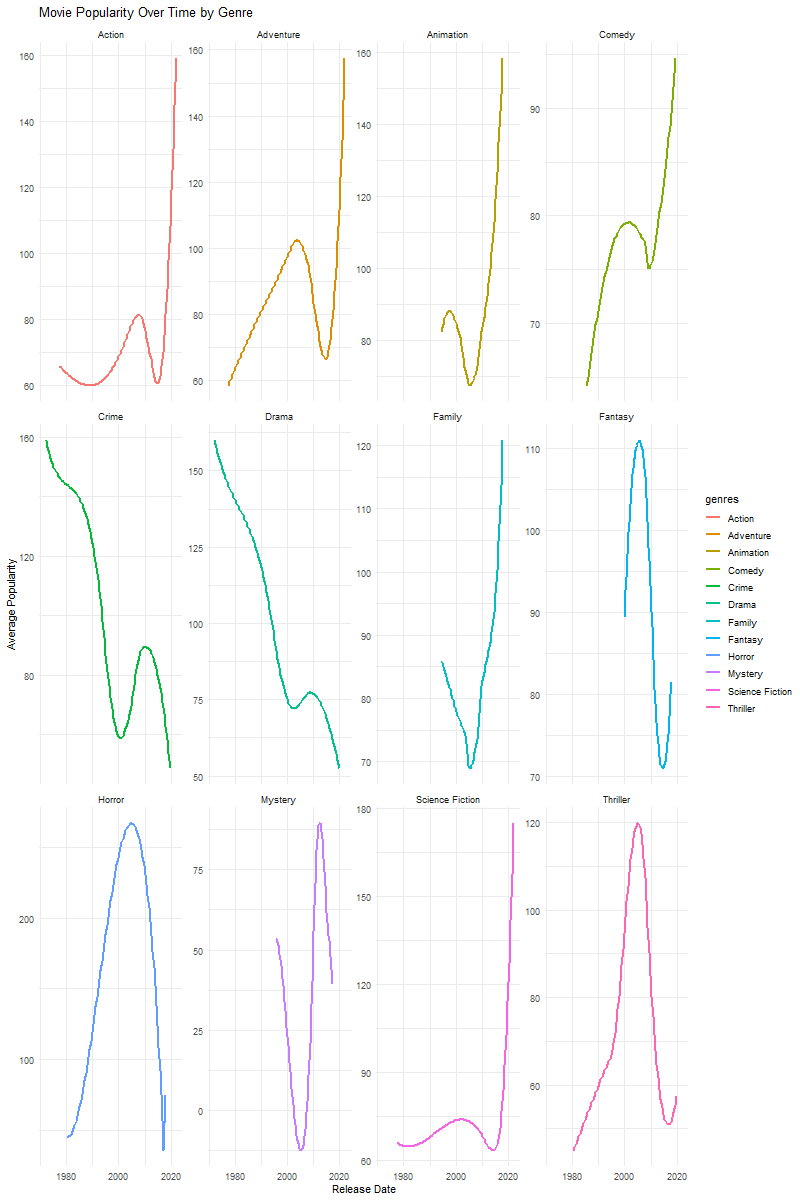

This line plot shows that most genres became more popular over time, except crime, drama and fantasy.  Horror movies and thrillers were popular only in the 2000s.

Our final line plot shows the audience engagement over time

In [ ]:
#line chart for audience engagement over time
movies <- slice(df, 1:100)

movies$release_date <- as.Date(movies$release_date)

# Aggregate the vote count data by release date
vote_count_by_date <- movies %>%
  group_by(release_date) %>%
  summarize(total_votes = sum(vote_count, na.rm = TRUE))

# Plot the line chart for audience engagement over time
ggplot(vote_count_by_date, aes(x = release_date, y = total_votes)) +
  geom_smooth(method = "loess", se = FALSE, span = 0.9) +
  labs(title = "Audience Engagement Over Time",
       x = "Release Date", y = "Total Votes")

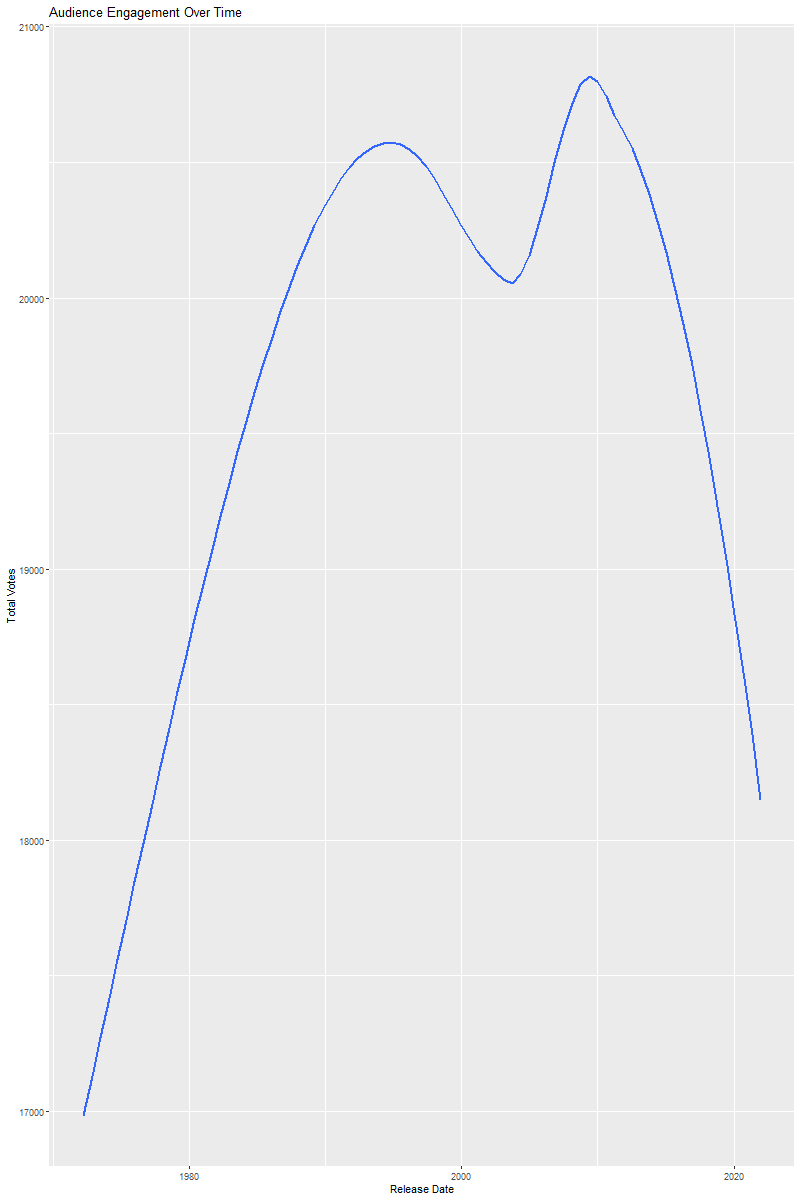

Most people rate movies released between 1990 and 2010. For some reason, 2000s movies are not rated as much.

# Wordclouds

Our first wordcloud shows top 30 longest movies

In [ ]:
# Top 30 longest movies

# Take popular, long movies
dflongest <- df %>% select(title, runtime, adult, popularity) %>%
  filter(runtime > 180, adult == "False", popularity > 50)

# Arrange by longest 
dflongest <- dflongest %>%
  arrange(desc(runtime))

# Take top 30
dflongest_30 <- dflongest %>%
  slice(1:30)

wordcloud(words = dflongest_30$title, freq = dflongest_30$runtime, scale = c(3,.1), colors = viridis(n = length(unique(dflongest_30$title))), rot.per = 0)

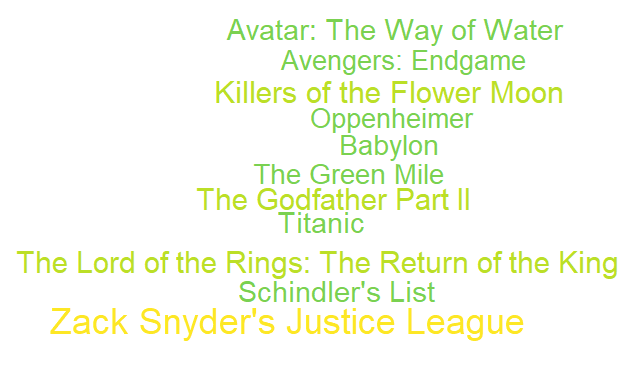

The longest film is Zack Snyder's Justice League. It is about 4 hours long.

2nd wordcloud shows the latest 15 movies as of today

In [ ]:
# Latest movies wordcloud

# Pick movies before today, select latest 15
dflatest <- df %>% select(title, release_date) %>%
  filter(release_date != "", as.Date(release_date) < Sys.Date()) %>%
  arrange(desc(release_date)) %>%
  slice(1:15)

# Convert release dates to numeric
dflatest$release_date <- as.numeric(as.Date(dflatest$release_date))

wordcloud(words = dflatest$title, freq = dflatest$release_date, colors = "Red", rot.per = 0)

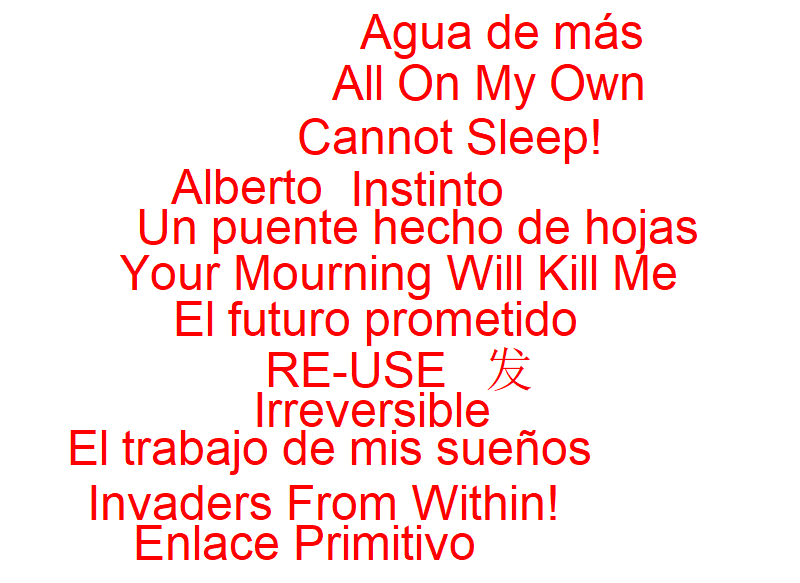

These are the latest movies as of the first time trying the code.

3rd wordcloud shows the top spoken languages, except english

In [ ]:
# Top spoken languages except english

# Take spoken languages except english, seperate by rows
dfsplang <- df %>% select(spoken_languages) %>%
  filter(spoken_languages != "") %>%
  separate_rows(spoken_languages, sep = ", ") %>%
  filter(spoken_languages != "English")

# Groupby languagse, arrange their frequencies
dfsplang <- dfsplang %>%
  group_by(spoken_languages) %>%
  summarise(frequency = n()) %>%
  filter(frequency > 1)%>%
  arrange(desc(frequency))

# Take top 15
dfsplang_15 <- dfsplang %>%
  slice(1:15)

wordcloud(words = dfsplang_15$spoken_languages, freq = dfsplang_15$frequency, colors = brewer.pal(15, "Greens")[6:9], rot.per = 0)

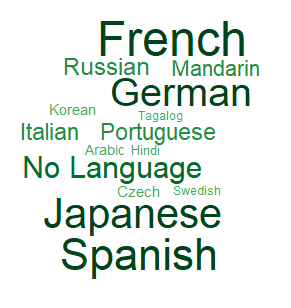

Most spoken languages except english are french, spanish, japanese and german. No language usually indicates a silent film, which are also common.

4th wordcloud shows TMDB's most popular movies

In [ ]:
# Most popular movies

# Take popular movies
dfmovie <- df %>% select(title, popularity, adult) %>%
  filter(popularity > 100, adult == "False")

# rrange by popularity
dfmovie <- dfmovie %>%
  arrange(desc(popularity))


# Take top 15
dfmovie_15 <- dfmovie %>%
  slice(1:15)

# Make brewer palette from "blues"
wordcloud(words = dfmovie_15$title, freq = dfmovie_15$popularity, colors = brewer.pal(15, "Blues")[6:9], rot.per = 0)

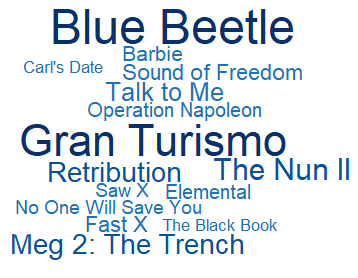

In TMDB's website, Blue Beetle and Gran Turismo are the most popular movies.

Our final wordcloud shows the top 50 keywords

In [ ]:
# Top 50 keywords

# Filter keywords, seperate them by rows
dfkey <- df %>% select(keywords, adult, popularity) %>%
  filter(keywords != "", popularity > 50, adult == "False") %>%
  separate_rows(keywords, sep = ", ")

# Most common keywords
dfkey <- dfkey %>%
  group_by(keywords) %>%
  summarise(frequency = n()) %>%
  filter(frequency > 1, keywords != "softcore")%>%
  arrange(desc(frequency))


# Take top 50
dfkey_50 <- dfkey %>%
  slice(1:50)

wordcloud(words = dfkey_50$keywords, freq = dfkey_50$frequency, colors = palette("Dark2"), rot.per = 0)

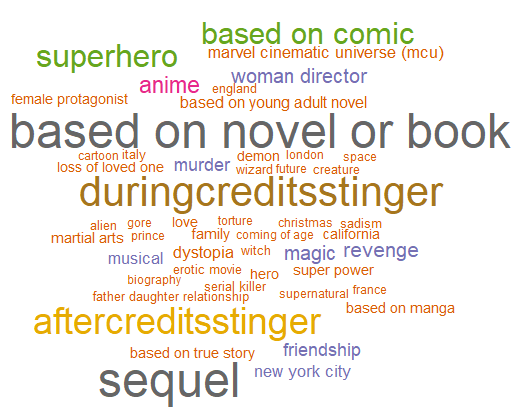

Sequels and movies based on novel or book are most common. 

# Input/Output

Multiple inpute and output code snippets. You can search movies by their genres, titles, duration, and many other things. First, we imported the dataset.

In [4]:
from cleaning import SeriesData
import pandas as pd

1. Cheking if the film is in the dataset

In [2]:
def is_the_film_in_dataset(film_name):
    # Make a copy of the SeriesData DataFrame to avoid modifying the original DataFrame
    SeriesData_copy = SeriesData.copy()

    # Drop rows with missing values in the 'title' column
    SeriesData_copy.dropna(subset=['title'], inplace=True)

    # Filter movies whose title contains the input film_name
    film_movies = SeriesData_copy[SeriesData_copy['title'].str.lower().str.contains(film_name.lower())]

    # Join the top 5 unique movie titles matching the criteria into a string
    return ', '.join(film_movies['title'].head(5).unique())

# Prompt the user to input the film name they want to check
check_film = input("Enter the film you want to check: ")

# Call the function to find movies with the input name in their title and print the result
print(f"This films have the name {check_film} in their title: {is_the_film_in_dataset(check_film)}")

This films have the name the avengers in their title: The Avengers, Building the Dream: Assembling the Avengers, The Avengers: A Visual Journey, The Avengers: Assembling the Ultimate Team


2. Outputting top 5 movies by genre

In [3]:
def _5_movies_by_genre(genre_name):
    # Make a copy of the SeriesData DataFrame to avoid modifying the original DataFrame
    SeriesData_copy = SeriesData.copy()

    # Filter movies by the specified genre, ignoring case and handling missing values
    genre_movies = SeriesData_copy[SeriesData['genres'].str.lower().str.contains(genre_name.lower(), case=False, na=False)]

    # Get the top 5 unique movie titles from the filtered DataFrame and join them into a string
    return ', '.join(genre_movies.head(5)['title'].unique())

# Prompt the user to input the genre they want to explore
genre_movies = input("Enter the gener you want: ")

# Call the function to get the top 5 movies by the specified genre and print the result
print(f"5 movies by genre: {_5_movies_by_genre(genre_movies)}")

5 movies by genre: Inception, Interstellar, Avatar, The Avengers, Deadpool


3. Giving the link to the film

In [4]:
def giving_the_link_to_film(film_name):
    # Filter DataFrame to find rows where movie title matches the input
    film_row = SeriesData[SeriesData['title'].str.lower() == film_name.lower()]

    # Check if the resulting DataFrame is not empty
    if not film_row.empty:
        # If movie is found, return its homepage link
        return film_row.iloc[0]['homepage']
    else:
        # return a message indicating it was not found
        return "Film not found"

# Prompt the user to input the movie name for which they want to get the link
wanted_film_name = input("Enter the film you want to watch: ")

# Call the function to get the link for the requested movie and print the result
result = giving_the_link_to_film(wanted_film_name)
print(f"{result}, this is link to film")

http://www.interstellarmovie.net/, this is link to film


4. Getting film's imdb id

In [5]:
def getting_imbd_id(film_name):
    # Filter DataFrame to find rows where movie title matches the input
    film_row = SeriesData[SeriesData['title'].str.lower() == film_name.lower()]

    # Check if the resulting DataFrame is not empty
    if not film_row.empty:
        # If movie is found, return its IMDb ID and a suggestion to search it on Google
        return f"{film_row.iloc[0]['imdb_id']} and you can search it in google"
    else:
        # If movie is not found, return a message indicating it was not found in the dataset
        return "Film not found in the dataset"

# Prompt the user to input the movie name for which they want to get the IMDb ID
film_you_want = input("Enter the film, which id you want to receive: " )
result_1 = getting_imbd_id(film_you_want)
print(f"The IMBD_ID of {film_you_want} is {result_1}")

The IMBD_ID of inception is tt1375666 and you can search it in google


5. Getting movie's information

In [15]:
def get_movie_info(movie_name):
    # Filter DataFrame to find rows where movie title or IMDb ID matches the input
    movie_row = SeriesData[(SeriesData['title'].str.lower() == movie_name.lower())
                           | (SeriesData['imdb_id'].str.lower() == movie_name.lower())]
    # Check if the resulting DataFrame is empty
    if movie_row.empty:
        # Print a message if no matching movie is found
        print(f"There is no film named {movie_name} in the dataset")
    else:
        # Return information about the movie if it is found
        return f"{movie_row['title'].values[0]} is produced by {movie_row['production_companies'].values[0]} \nIts genre is {movie_row['genres'].values[0]} and Its Imbd_Id is {movie_row['imdb_id'].values[0]}\nIt is released {movie_row['release_date'].values[0]} and It is in {movie_row['spoken_languages'].values[0]} languages"

# Prompt the user to input the movie name or IMDb ID for which they want to receive information
movie_title = input("Enter the movie name od imdb id for which you want receive an info: ")

# Call the function to get information about the movie and print the result
movie_info = get_movie_info(movie_title)
print(movie_info)

Deadpool is produced by 20th Century Fox, The Donners' Company, Genre Films 
Its genre is Action, Adventure, Comedy and Its Imbd_Id is tt1431045
It is released 2016-02-09 and It is in English languages


6. Finding similar movies

In [11]:
def films_like(film_name):
    # Filter DataFrame to find rows where movie title matches the input
    film_row = SeriesData[SeriesData['title'].str.lower() == film_name.lower()]

    # Check if the resulting DataFrame is empty
    if film_row.empty:
        # Print a message if no matching movie is found
        print(f"There is no film named {film_name} in the dataset")
    else:
        # If movie is found, continue with the analysis

        # Make a copy of the SeriesData DataFrame to avoid modifying the original DataFrame
        SeriesData_copy = SeriesData.copy()

        # Exclude the movie itself from the similar movies
        SeriesData_changed = SeriesData_copy[SeriesData_copy['title'].str.lower() != film_name.lower()]

        # Get the genre of the input movie
        genre = film_row['genres'].values[0]

        # Filter out movies with missing values in the 'genres' column
        similar_movies = SeriesData_changed.dropna(subset=['genres'])

        # Convert 'vote_average' column to numeric, handling errors by coercing to NaN
        similar_movies.loc[:,'vote_average'] = pd.to_numeric(similar_movies['vote_average'], errors='coerce')

        # Sort movies by 'vote_average' in descending order
        similar_movies = similar_movies.sort_values(by='vote_average', ascending=False)

        # Filter movies with genres similar to the input movie's genre
        similar_movies_final = similar_movies[similar_movies['genres'].str.contains(genre)]

        # Return a string containing the titles of the top 5 similar movies
        return ', '.join(similar_movies_final.head(5)['title'].unique())

# Prompt the user to input the film name for which they want to find similar movies
film_like_smth = input("Enter the film name for which you want to find similar movies: ")

# Call the function to find movies similar to the input film and print the result
film_similar_to = films_like(film_like_smth)
print(f"{film_similar_to}, these films are similar to {film_like_smth}")

Bootleg Beck and the Internet Pirates, Sir Gawain And The Green Knight, SnapCube's Real-Time Fandub: Sonic the Hedgehog, Wasabi V.S. Aliens, Zorori the Naughty Hero: The Secret of Double Z, these films are similar to barbie


7. Getting movies by preferable length and genre

In [13]:
def movie_lenght(time, genre):
    # Make a copy of the SeriesData DataFrame to avoid modifying the original DataFrame
    SeriesData_copy = SeriesData.copy()
    SeriesData_copy = SeriesData_copy[SeriesData_copy['adult'] == False]

    # Filter movies by the specified genre, ignoring case and handling missing values
    SeriesData_1 = SeriesData_copy[SeriesData['genres'].str.lower().str.contains(genre.lower(), case=False, na=False)]

    # Filter movies by the specified maximum runtime
    SeriesData_time = SeriesData_1[SeriesData_1['runtime'] <= time]

    # Convert 'vote_average' column to numeric, handling errors by coercing to NaN
    SeriesData_time.loc[:, 'vote_average'] = pd.to_numeric(SeriesData_time['vote_average'], errors='coerce')

    # Drop rows with NaN values in 'vote_average' column
    SeriesData_time.dropna(subset=['vote_average'])

    # Sort movies by 'vote_average' in descending order
    SeriesData_time_rating = SeriesData_time.sort_values(by='vote_average', ascending=False)

    # Return the top 5 unique movie titles with runtime less than or equal to the specified time
    return ', '.join(SeriesData_time_rating['title'].head(5).unique())

# Prompt the user to input the maximum runtime and the desired genre
time_you_want = input("how long do you want the film be in minutes?")
time_you_want = int(time_you_want)
genre_1 = input("what genre do you want the film")

# Call the movie_length function to get the movies matching the criteria and print the result
result = movie_lenght(time_you_want, genre_1)
print(f"{result}, these are the movies which lenghth is less than {time_you_want} minutes and its genre is {genre_1}")

C:\Users\Annkh\AppData\Local\Temp\ipykernel_22916\2778702000.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  SeriesData_1 = SeriesData_copy[SeriesData['genres'].str.lower().str.contains(genre.lower(), case=False, na=False)]


The Cowgirl and the Ballerina, City On Fire, Underground Cemetery, Black Mask, An Evening with B.B., these are the movies which lenghth is less than 120 minutes and its genre is drama


8. Finding movies by language

In [8]:
def which_language(language):
    # Make a copy of the SeriesData DataFrame to avoid modifying the original DataFrame
    SeriesData_copy = SeriesData.copy()
    SeriesData_copy = SeriesData_copy[SeriesData_copy['adult'] == False]

    # Filter movies by the specified language
    SeriesData_language = SeriesData_copy[SeriesData_copy['spoken_languages'].str.lower() == language.lower()]

    # Convert 'vote_average' column to numeric, handling errors by coercing to NaN
    SeriesData_language.loc[:,'vote_average'] = pd.to_numeric(SeriesData_language['vote_average'], errors='coerce')

    # Drop rows with NaN values in 'vote_average' column
    SeriesData_language.dropna(subset=['vote_average'])

    # Sort movies by 'vote_average' in descending order
    SeriesData_language_sorted = SeriesData_language.sort_values(by='vote_average', ascending=False)

    # Return the top 5 unique movie titles in the specified language
    return ', '.join(SeriesData_language_sorted['title'].head(5).unique())

# Prompt the user to input the language they want to explore
lan = input("Enter the language you want ")

# Call the which_language function to get the top movies in the specified language and print the result
result = which_language(lan)
print(f"The language is {lan}, and most high rated movies are on these language are: {result}")

The language is french, and most high rated movies are on these language are: Frantz Fanon, mémoire d'asile, Indochine - Black City Concert - Stade de France 2014, The Nicole Brothers, Born To Climb, Miko the clairvoyant chef, Lyon Premier 8000, Au Gasherbrum II - 8035m
